# Catchment Distance

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import osmnx as ox
import networkx as nx

In [2]:
churches = ['mossleyhill','sthelens','gateway','stoneycroftsalvationarmy']

data = {}
for church in churches:
    data[church] = pd.read_csv(f'../data/sensitive/derived/{church}.csv')

In [4]:
pcdlatlng = pd.read_csv('../data/csv/pcdlatlng.csv.gz')

In [5]:
location = {'mossleyhill' : 'L18 8DB',
            'sthelens' : 'WA10 2DT',
            'gateway' : 'L24 9HJ',
            'stoneycroftsalvationarmy': 'L13 3BT'}

In [6]:
def get_coords(postcode):
    "Lookup coordinates from conversion table."
    row = pcdlatlng.loc[pcdlatlng.postcode==postcode].iloc[0]
    return row.latitude, row.longitude

In [7]:
distance = {}
shortest = {}
all_routes = {}

In [8]:
mile = 1609 # metres
BigMap = ox.graph_from_point(get_coords(location['mossleyhill']), distance=20*mile, network_type='drive')

In [9]:
def get_distances(church):
    
    church_coords = get_coords(location[church])
    dest_node = ox.get_nearest_node(BigMap, church_coords)
    shortest[church] = {}
    distance[church] = {}
    all_routes[church] = []
    exceptions = []
    postcodes = list(data[church].Postcode)
    
    for postcode in postcodes:
        try:
            orig_node = ox.get_nearest_node(BigMap, get_coords(postcode))
            shortest[church][postcode] = nx.shortest_path(BigMap, orig_node, dest_node, weight='length')
            distance[church][postcode] = nx.shortest_path_length(BigMap, orig_node, dest_node, weight='length') / mile
            all_routes[church].append(shortest[church][postcode])
        except:
            exceptions.append(postcode)
            postcodes.remove(postcode)
    
#     print(f'Could not find {exceptions} -- are these valid postcodes?')
            
    return distance[church]

In [10]:
for church in churches:
    print(church)
    distance[church] = get_distances(church)

mossleyhill
sthelens
gateway
stoneycroftsalvationarmy


In [11]:
dist_df = {}
for church in churches:
    dist_df[church] = pd.DataFrame(distance[church],index=['Distance']).T
    dist_df[church].reset_index(inplace=True)
    dist_df[church].rename(columns={'index':'Postcode'},inplace=True)
    if 'Distance' not in data[church].columns:
        data[church] = pd.merge(data[church], dist_df[church],on='Postcode')
    data[church].to_csv(f'../data/sensitive/derived/{church}.csv',index=False)

## Travel Distances

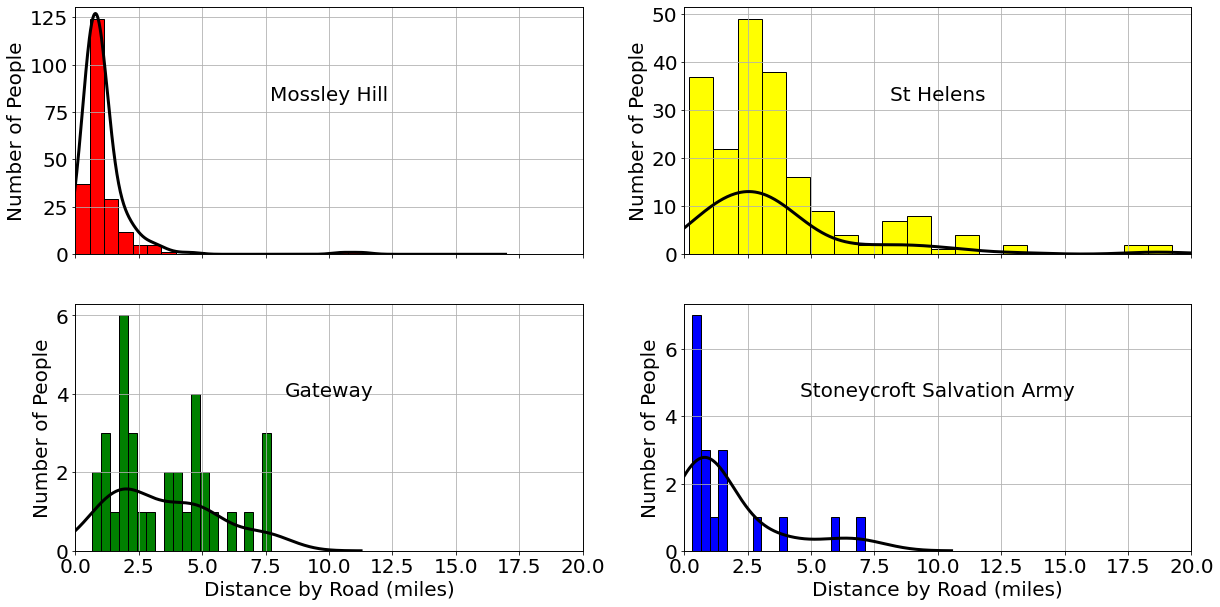

In [34]:
colors = ['red','yellow','green','blue']
church_name = ['Mossley Hill', 'St Helens', 'Gateway', 'Stoneycroft Salvation Army']

fig, axs = plt.subplots(2,2,figsize=(20,10))
fontsize = 20
for i, church in enumerate(churches):
    j = i//2
    k = i%2
    ax=axs[j][k]
    ax2 = ax.twinx()
    data[church].Distance.plot.kde(ax=ax2,c='black',lw=3)
    data[church].Distance.hist(ax=ax, bins=20,facecolor=colors[i],edgecolor='black')
    ax2.set_ylim(0,0.7)
    ax2.set_ylabel('')
    ax2.set_yticks([])
    ax2.tick_params(labelsize=fontsize)
    ax.tick_params(labelsize=fontsize)
    ax.set_ylabel('Number of People',fontsize=fontsize)
    ax.set_xlabel('Distance by Road (miles)',fontsize=fontsize)
    ax.set_xlim(0,20)
    ax.set_title(f'{church_name[i]}',y=0.6,fontsize=fontsize)
# plt.tight_layout()
# plt.suptitle('Distances People Travel to Church',y=0,fontsize=fontsize)
plt.show()

## Visualizing Travel Routes

In [12]:
def show_catchment(church, miles, G=None):
    
    if not G:
        G = ox.graph_from_point(get_coords(location[church]), distance=miles*mile, network_type='drive')
    church_coords = get_coords(location[church])
    nearby_postcodes = []
    nearby_routes = []
    postcodes = list(data[church].Postcode)
    for postcode in postcodes:
        try:
            if distance[church][postcode] < miles:
                nearby_postcodes.append(postcode)
                nearby_routes.append(shortest[church][postcode])
        except:
            print(f'{postcode} is more than {miles} miles away.')
    
    fig, ax = ox.plot_graph_routes(G,
                                   nearby_routes,
                                   fig_height=20,
                                   node_size=0,
                                   orig_dest_node_size=10,
                                   edge_alpha=0.3,
                                   route_alpha=0.7,
                                   route_linewidth=1,
                                   show=False,
                                   close=False)
    
    ax.scatter(church_coords[1],church_coords[0],c='red',alpha=1)
    return ax

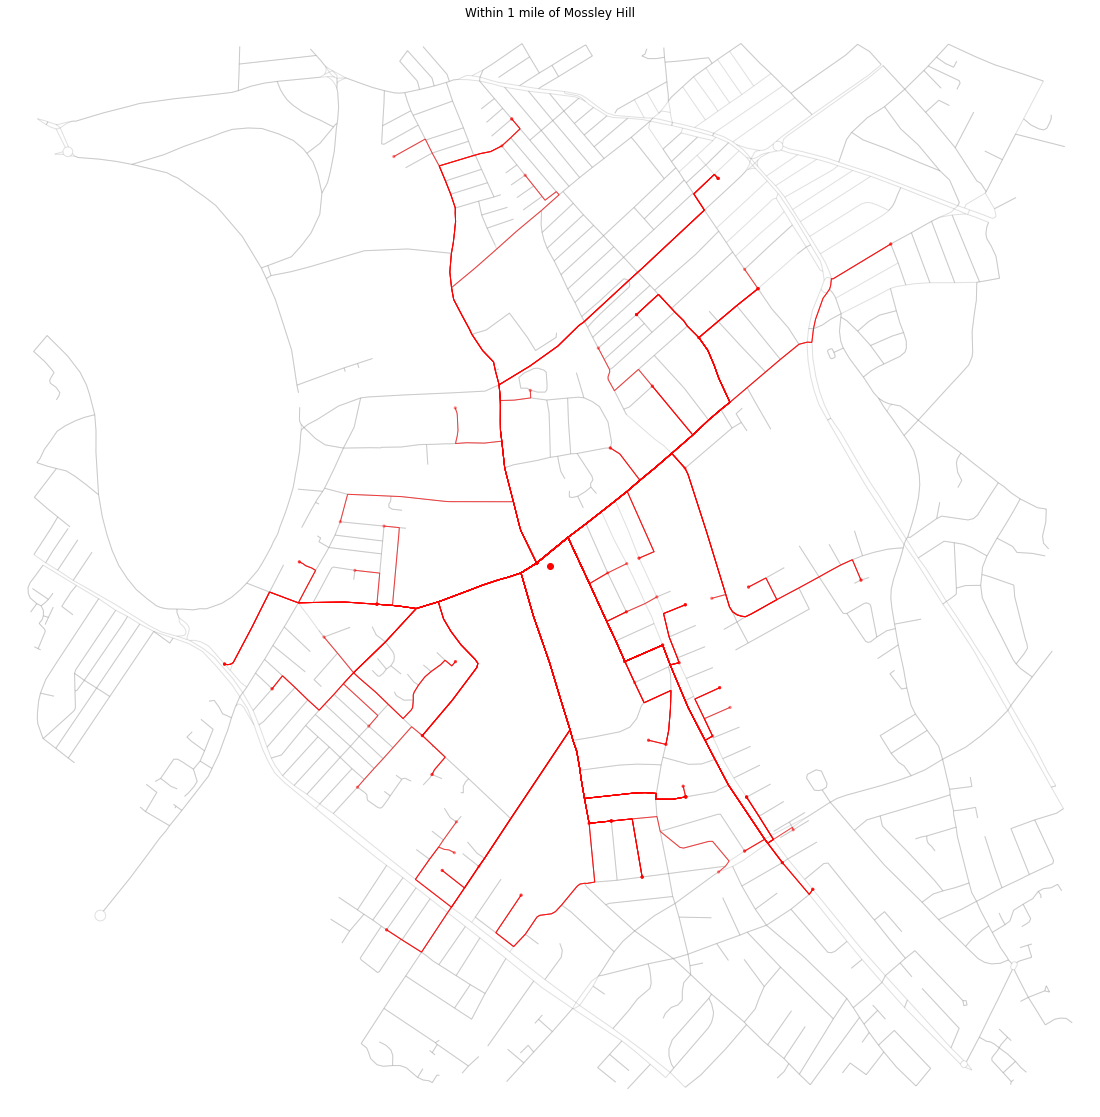

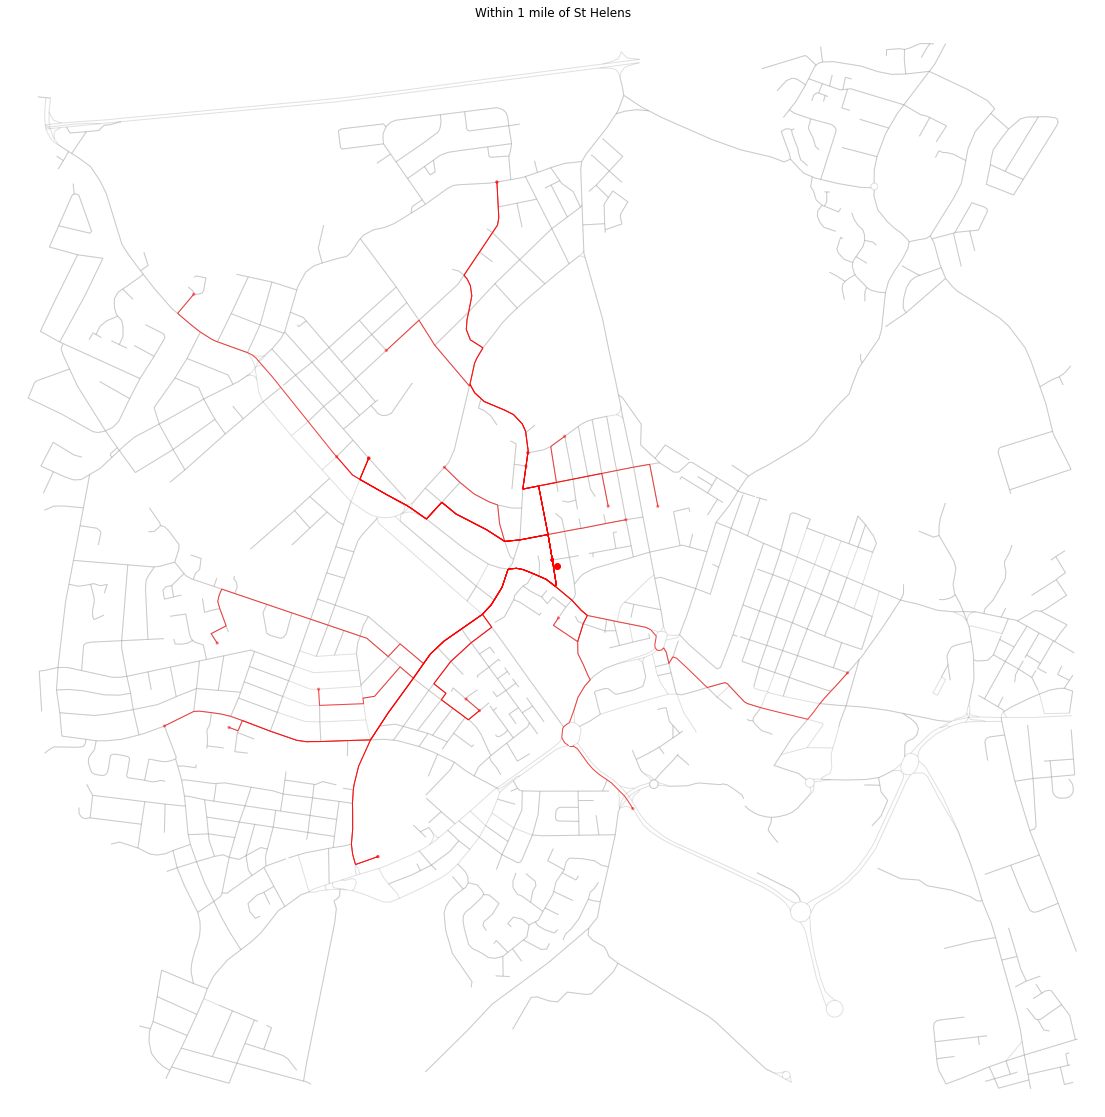

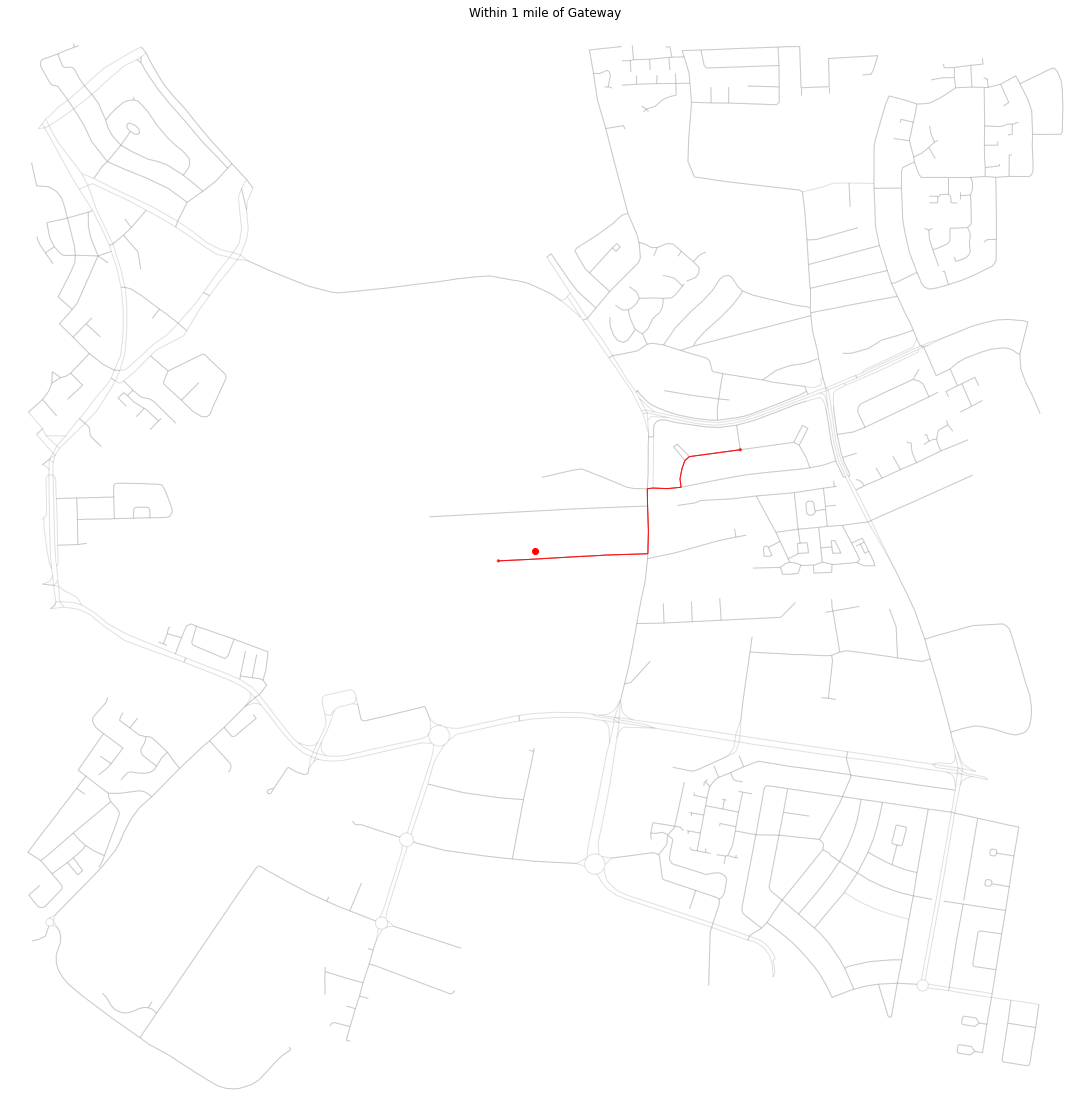

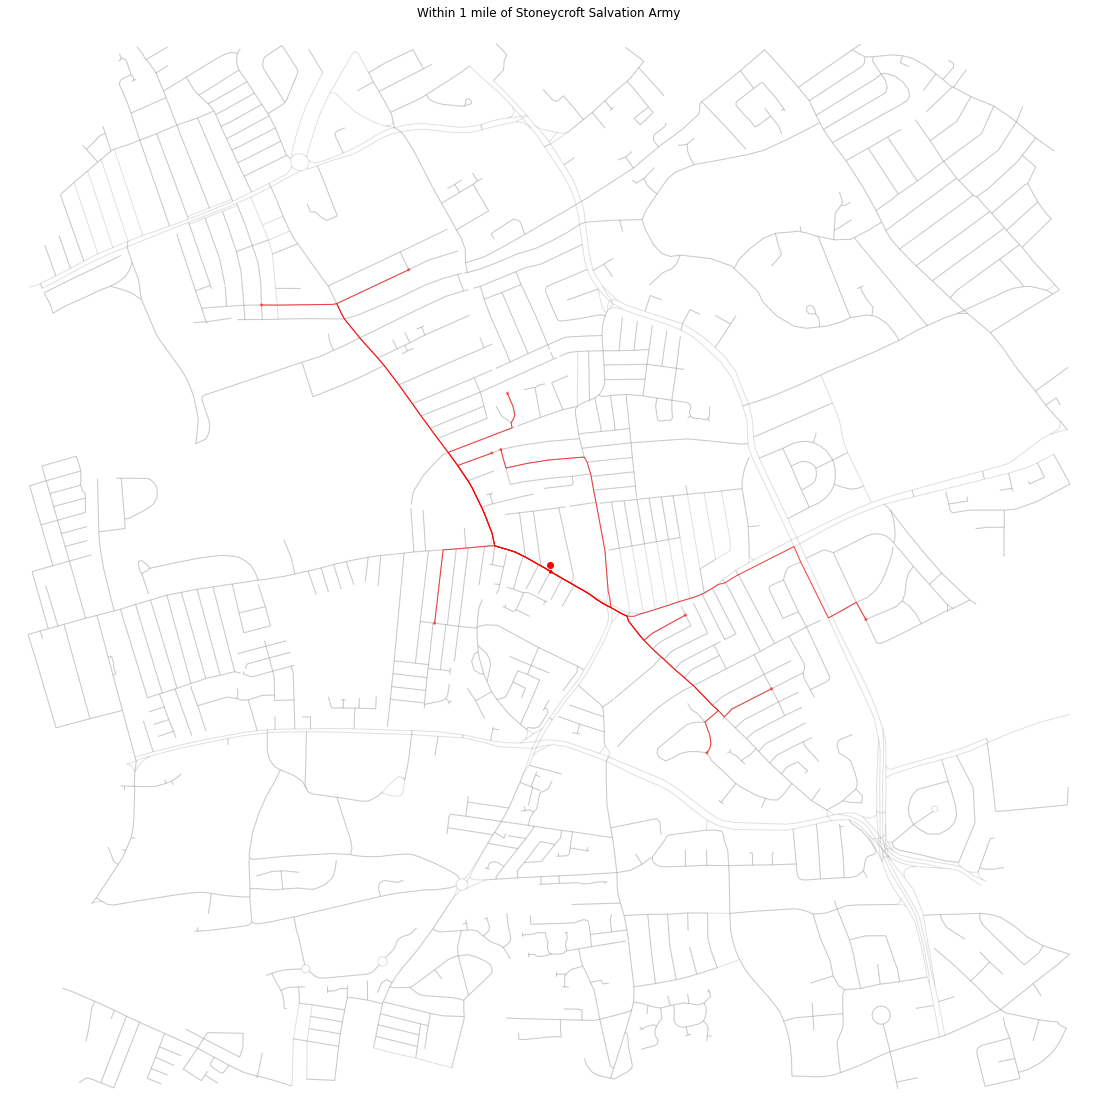

In [13]:
for i, church in enumerate(churches):
    ax = show_catchment(church, 1)
    ax.set_title(f'Within 1 mile of {church_name[i]}')
    

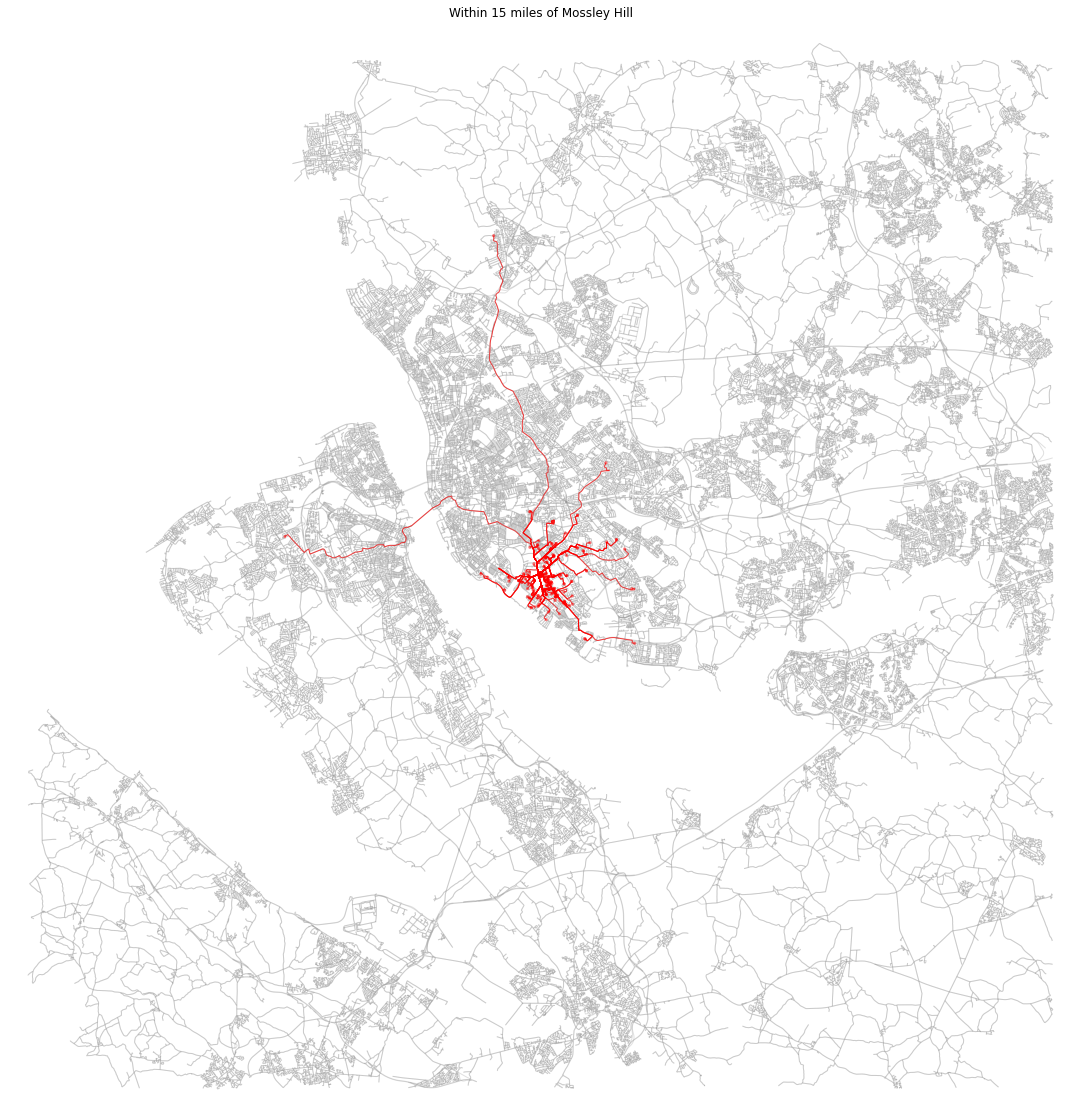

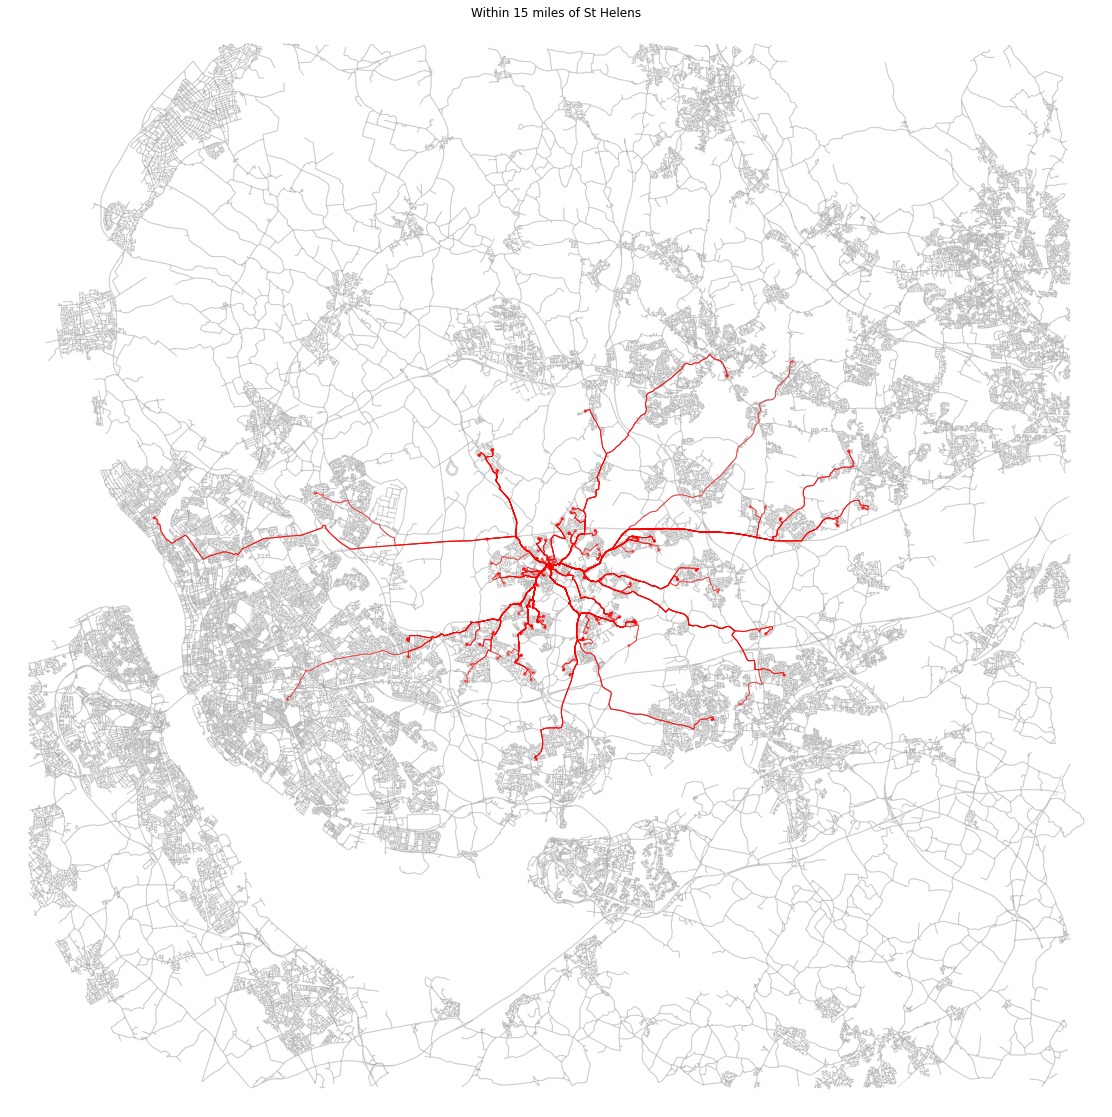

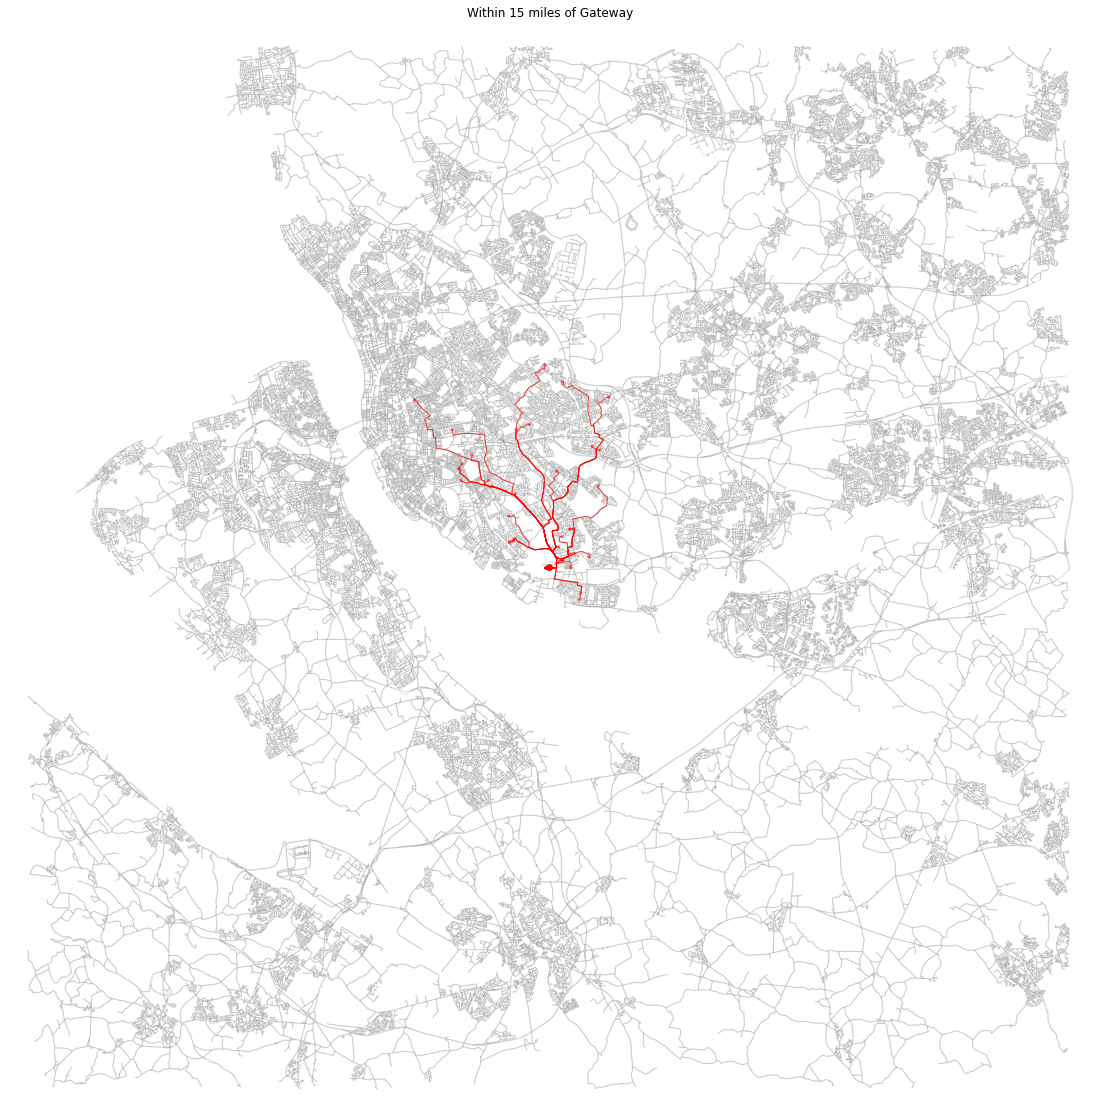

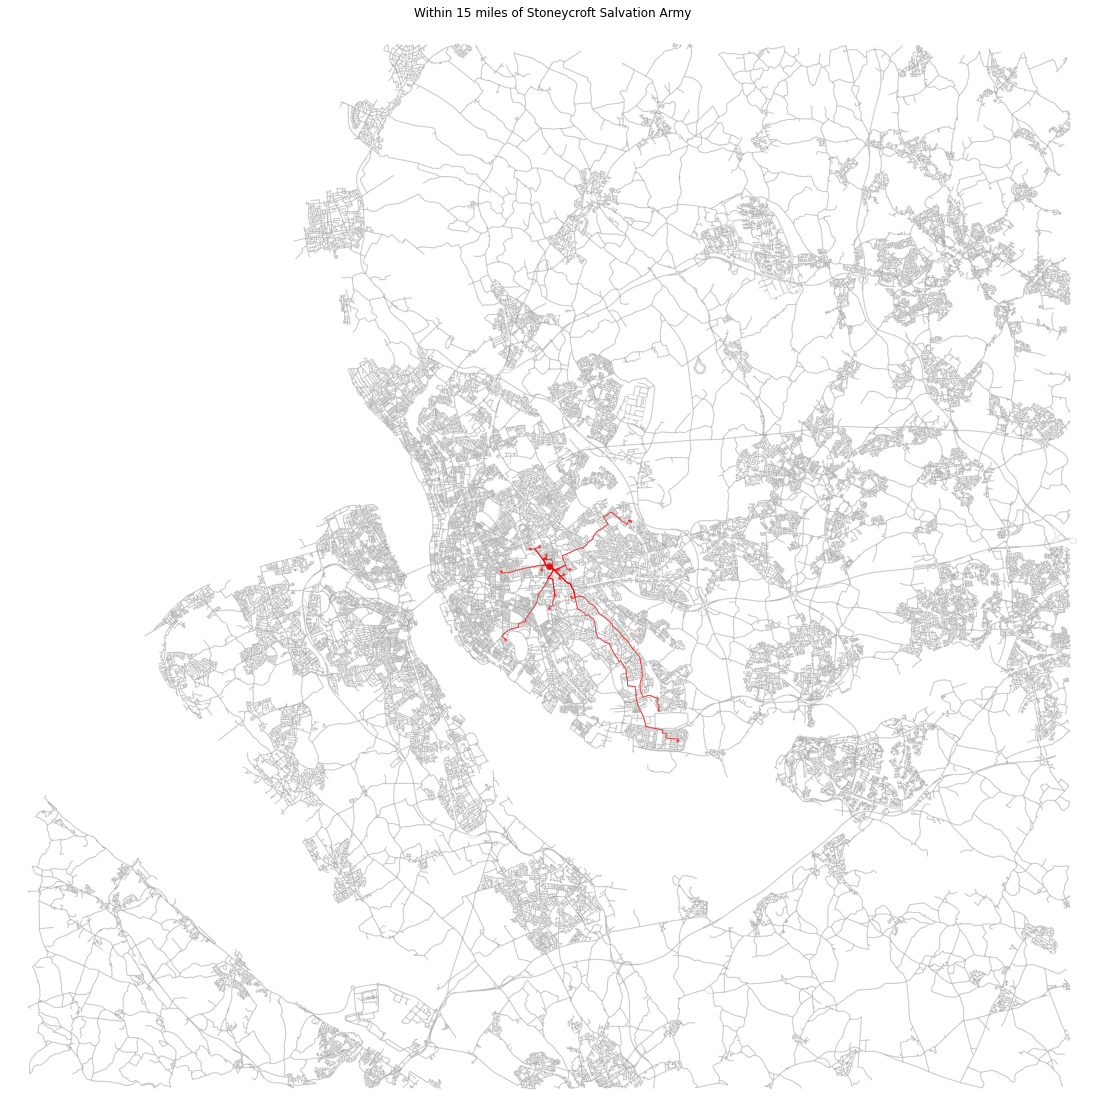

In [14]:
for i, church in enumerate(churches):
    ax = show_catchment(church, 15)
    ax.set_title(f'Within 15 miles of {church_name[i]}')